# Digital Forensics Project: Generative Adversarial Network
## Generative Adversarial Network on FashionMNIST and DeepFashion Datasets
### Marchiori Francesco, ID: 2020389
### [Fashion MNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist)

## Importing the libraries

Other than the basic libraries needed in Python, Tensorflow is used (with Keras as its backend) in order to implement the GAN.

In [1]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
from IPython import display
import numpy as np

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.utils.vis_utils import plot_model

## Importing the Dataset

The [Fashion MNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist) is imported. It can be done by importing images or a .csv file, but since the `fashion_mnist.load_data()` loads the same dataset in a more convenient way, this way will be used. After that, the images are reshaped and normalized for the processing, resulting in 60000 images with resolution 28x28 with one channel (since they're not RGB) and pixel value between -1 and 1.

In [2]:
(x_train, y_train), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# String array for printing the labels
labels = ['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalization of the images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') # Size normalization
x_train = (x_train - 127.5) / 127.5  # Value normalization (in order to have values in [-1, 1])

print('Number of images in the training set:', len(x_train))

Number of images in the training set: 60000


### Dataset Plots

Some examples are generated in order to show what the dataset looks like.

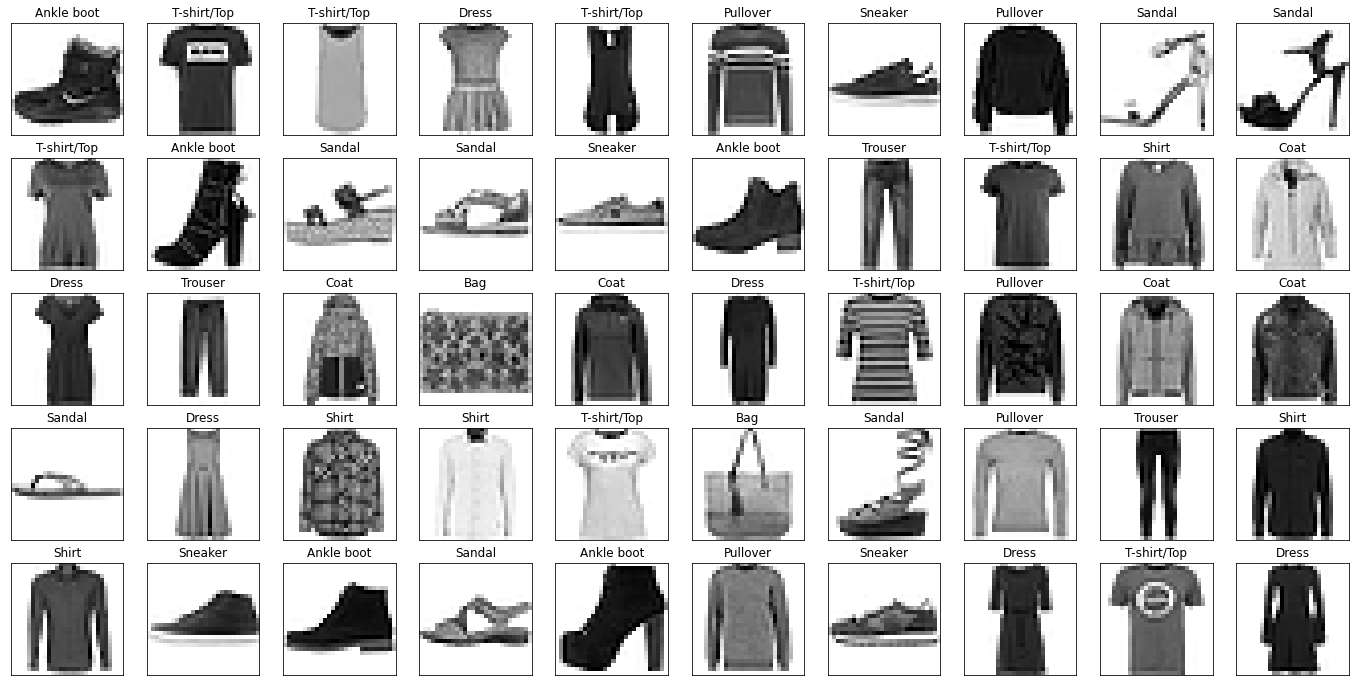

In [3]:
plt.figure(figsize=(24, 12))

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(labels[y_train[i]])
    plt.imshow(x_train[i], cmap=plt.cm.binary)

plt.show()

### Creation of the dataset

Starting from *x_train*, a dataset with batches of size 256 is created. This time, since the aim is to build a conditional GAN, also the labels *y_train* will be included.

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print('Dividing a buffer of size', BUFFER_SIZE, 'in batches of size', BATCH_SIZE, '\nNumber of batches in the dataset:', len(dataset))

Dividing a buffer of size 60000 in batches of size 256 
Number of batches in the dataset: 235


## cGAN Model

In the following section the definitions of the generator and discriminator of the model are presented. Since the dataset is composed by images and labels, the prevalent layer type will be the Convolutional Layer which makes these models Convolutional Neural Network, machine learning models particularly suited for the processing of images. However, since there are also labels in the dataset, the models will take in input both the image and the label, therefore a `Concatenate` layer will be necessary in order to merge the values coming from the two different inputs.

### Generator Model

The generator takes in input some random noise and a label and returns in output a 28x28 image (with pixel value $\in [-1, 1]$ as the images in the dataset). The label passes through an `Embedding` layer which maps it to a 100 element vector and passes through a `Dense` layer before getting reshaped in order to match the size of the seed of the image, which in turn gets processed as a 7x7 image with 128 channels. Therefore, in the `Concatenate` layer the label and the image are merged in a single 7x7 image with 129 channels (with the last one being the one coming from the label). After that, a similar processing as the standard GAN is done.

In [5]:
def generator_model():
	"""
	Defines the generator model for the cGAN using TensorFlow layers.
	
	INPUT: random noise and a label
	OUTPUT: 28x28 image with pixel value between -1 and 1
	"""
	
	# Label Input
	label = layers.Input(shape=(1,), name='Label_Input')
	# Embedding layer: takes the 10 possible labels and maps them in a vector of size 100
	embedding = layers.Embedding(input_dim=10, output_dim=100, name='Embedding')(label)
	# Dense layer
	dense_label = layers.Dense(7*7, name='Dense_Label')(embedding)
	# Reshape
	reshape_label = layers.Reshape((7, 7, 1), name='Reshape_Label')(dense_label)

	# Image Generator Input
	image_gen = layers.Input(shape=(100,), name='Image_Seed_Input')
	# Pre-processing
	dense_img = layers.Dense(7*7*128, name='Dense_Img')(image_gen)
	batch_norm = layers.BatchNormalization(name='Batch_Normalization')(dense_img)
	act = layers.LeakyReLU(name='Leaky_ReLU_Img')(batch_norm)
	reshape_img = layers.Reshape((7, 7, 128), name='Reshape_Img')(act)

	# Concatenation of label and image
	merge = layers.Concatenate(name='Concatenate')([reshape_img, reshape_label])

	# Then, a similar model to the previously presented GAN is built
	# First Upsampling
	x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_1')(merge)
	x = layers.LeakyReLU(name='Leaky_ReLU_1')(x)

	# Second Upsampling
	x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_2')(x)
	x = layers.LeakyReLU(name='Leaky_ReLU_2')(x)

	# Output
	output = layers.Conv2D(1, (7, 7), activation='tanh', padding='same', name='Conv2D')(x)

	# Model definition
	return models.Model([image_gen, label], output, name='Generator')

In [6]:
generator = generator_model()
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Seed_Input (InputLayer)   [(None, 100)]        0                                            
__________________________________________________________________________________________________
Dense_Img (Dense)               (None, 6272)         633472      Image_Seed_Input[0][0]           
__________________________________________________________________________________________________
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Batch_Normalization (BatchNorma (None, 6272)         25088       Dense_Img[0][0]                  
__________________________________________________________________________________________

### Noise plots

Some examples are now generated by creating 16 instances of noise and, by taking them as input in the generator model, the output images are plotted.

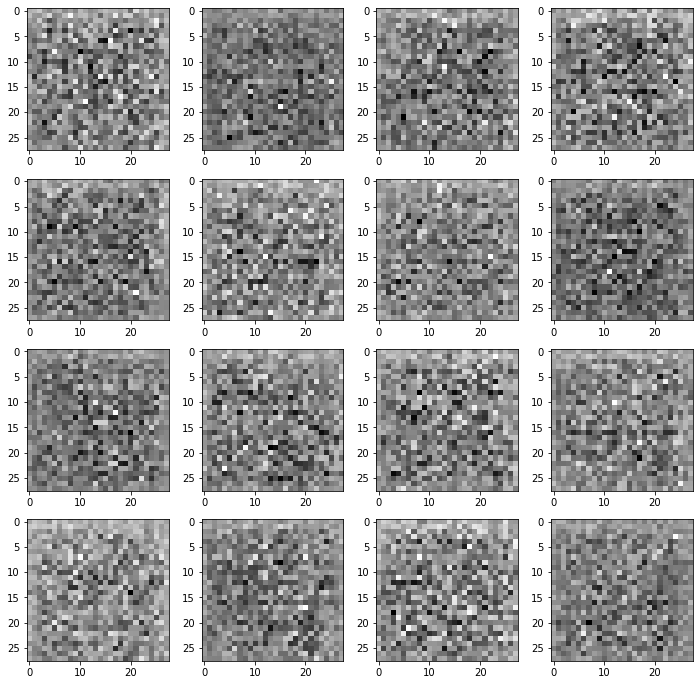

In [7]:
noise = tf.random.normal([16, 100])
generated_image = generator((noise, np.zeros(16)), training=False)

plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_image[i], cmap=plt.cm.binary)

## Discriminator Model

The discriminator takes in input some some 28x28 images (with pixel value $\in [-1, 1]$) and a label and returns in output a value between 0 and 1. This output represent the prediction of the discriminator of the image taken in input, where 0 means that the image is fake and 1 means that the image is real. As the generator, it uses and `Embedding` layer to map the label to a 100 element vector and process it by reshaping it accordingly. It then uses the `Concatenate` layer and the processing done after that is similar to the one saw in the standard GAN discriminator.

In [8]:
def discriminator_model():
	"""
	Defines the discriminator model for the GAN using TensorFlow layers.
	
	INPUT: 28x28 image with pixel value between -1 and 1 and a label
	OUTPUT: value between 0 and 1 (0 = fake image, 1 = real image)
	"""
	
	# Label Input
	label = layers.Input(shape=(1,), name='Label_Input')
	# Embedding layer: takes the 10 possible labels and maps them in a vector of size 100
	embedding = layers.Embedding(input_dim=10, output_dim=100, name='Embedding')(label)
	# Dense layer
	dense_label = layers.Dense(28*28, name='Dense_Label')(embedding)
	# Reshape
	reshape_label = layers.Reshape((28, 28, 1), name='Reshape_Label')(dense_label)

	# Image Input
	image = layers.Input(shape=(28, 28, 1), name='Image_Input')

	# Concatenation of label and image
	merge = layers.Concatenate(name='Concatenate')([image, reshape_label])

	# Then, a similar model to the previously presented GAN is built
	# First Downsampling
	x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_1')(merge)
	x = layers.LeakyReLU(name='Leaky_ReLU_1')(x)
	# Second Downsampling
	x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', name='Conv2DT_2')(x)
	x = layers.LeakyReLU(name='Leaky_ReLU_2')(x)
	# Flatten feature maps
	x = layers.Flatten(name='Flatten')(x)
	# Dropout
	x = layers.Dropout(0.3, name='Dropout')(x)
	# Output
	output = layers.Dense(1, activation='sigmoid', name='Sigmoid')(x)

	# Model definition
	return models.Model([image, label], output, name='Discriminator')

In [9]:
discriminator = discriminator_model()
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Label_Input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 1, 100)       1000        Label_Input[0][0]                
__________________________________________________________________________________________________
Dense_Label (Dense)             (None, 1, 784)       79184       Embedding[0][0]                  
__________________________________________________________________________________________________
Image_Input (InputLayer)        [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

## Loss and Optimization

In order to train the model, it's now important to define its loss and its optimizers

In [10]:
# Set the cross entropy

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def generator_loss(fake_output):
    """ Function for the calculation of the generator loss """
    
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [12]:
def discriminator_loss(real_output, fake_output):
    """ Function for the calculation of the discriminator loss """

    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

    return real_loss + fake_loss

In [13]:
# Setting up the optimizers for the models

generator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

In [14]:
# Arrays for the losses

g_loss = []
d_loss = []

## Training

It's now time to train the model. However, to do so it's necessary to define the number of epochs, the noise dimension and thoroughly define the training procedure.

In [15]:
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 50
images_seed = tf.random.normal([num_examples_to_generate, noise_dim])
labels_seed = np.array([])

for seed_name, i in zip(labels, range(len(labels))):
    labels_seed = np.append(labels_seed, np.full((5), labels.index(seed_name)))

print(labels_seed)

[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4.
 4. 5. 5. 5. 5. 5. 6. 6. 6. 6. 6. 7. 7. 7. 7. 7. 8. 8. 8. 8. 8. 9. 9. 9.
 9. 9.]


In [16]:
@tf.function
def train_step(images, labels):
    """ Function for the definition of a train step """

    # Generate the noise
    noise = tf.random.normal([images.shape[0], noise_dim])

    # Generate the images from the noise with the generator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator((noise, labels), training=True)

      # Give in input to the discriminator both the real and the fake images with the labels
      real_output = discriminator((images, labels), training=True)
      fake_output = discriminator((generated_images, labels), training=True)

      # Compute the losses for generator and discriminator
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # Compute the gradients for generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply learned gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [17]:
def generate_and_save_images(model, epoch, test_input, label_input):
  """ Function for the generation and saving the images """

  predictions = model((test_input, label_input), training=False)

  fig = plt.figure(figsize=(24, 12))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 10, i + 1)
      plt.title(labels[int(label_input[i])])
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray_r')
      plt.axis('off')

  plt.savefig('./Images/Epoch_{:04d}.png'.format(epoch))
  plt.show()

In [18]:
def train(dataset, epochs):
  """ Defines all the actions that are done during training """

  for epoch in range(epochs):
    start = time.time()

    for image_batch, label_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch, label_batch)

    # Save losses of the epoch
    g_loss.append(gen_loss.numpy())
    d_loss.append(disc_loss.numpy())

    # Clear output
    display.clear_output(wait=True)

    # Print losses
    print('Generator loss: {}\nDiscriminator loss: {}'.format(gen_loss.numpy(), disc_loss.numpy()))

    # Produce images
    generate_and_save_images(generator, epoch + 1, images_seed, labels_seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)

  generate_and_save_images(generator, epochs, images_seed, labels_seed)

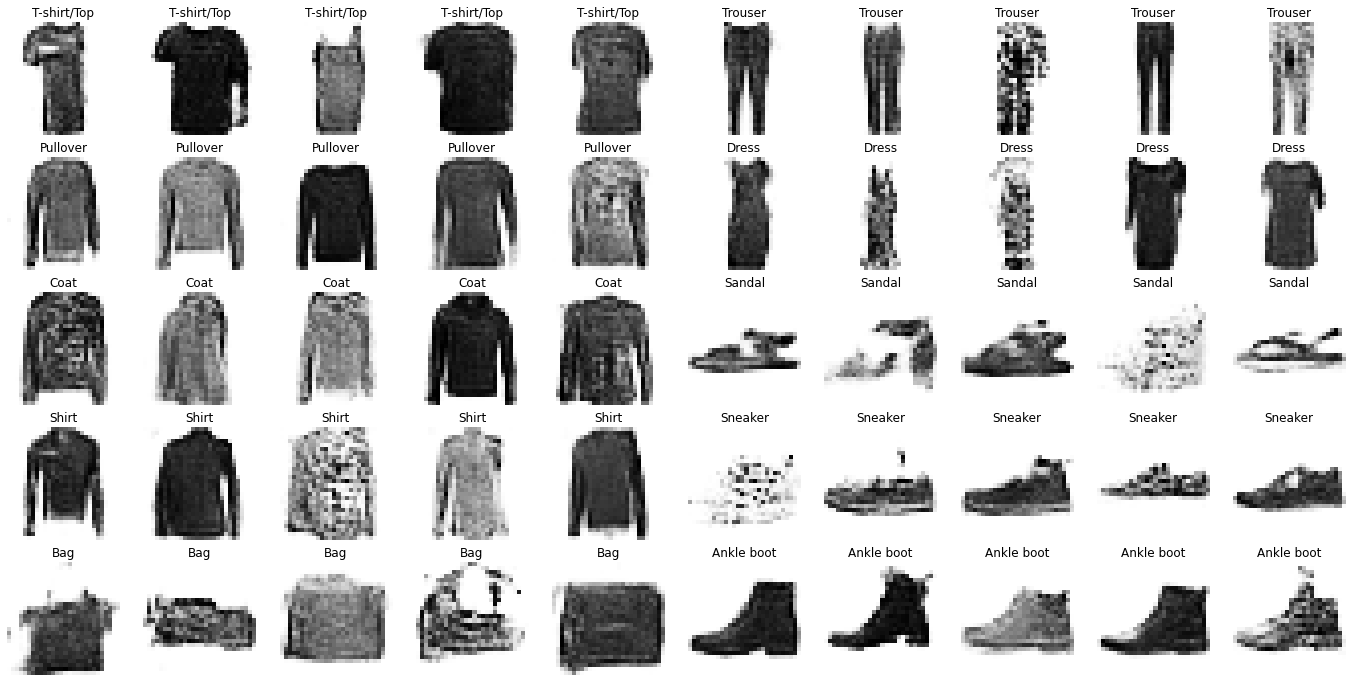

In [19]:
train(dataset, EPOCHS)

## Losses Plots

Generate the plot of the losses for both the generator and the discriminator.

In [20]:
def plot_losses(losses, title):
    """ Plots the losses given in input """

    epochs = len(losses)

    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.plot(losses)
    plt.savefig('./Losses/' + title + '_cGAN.png', bbox_inches='tight')
    plt.show()

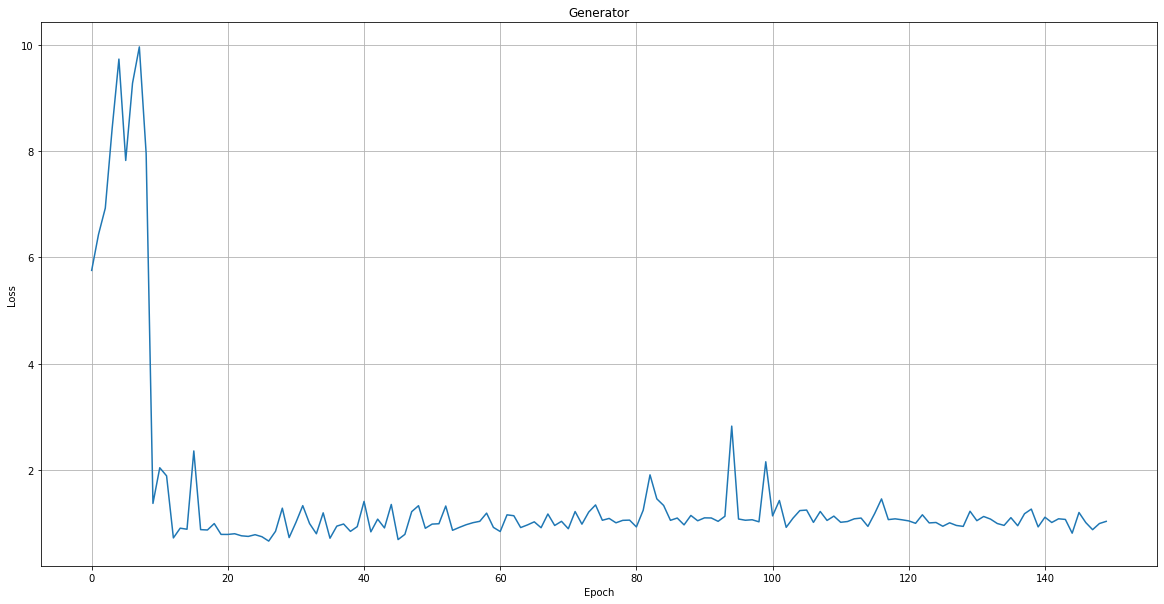

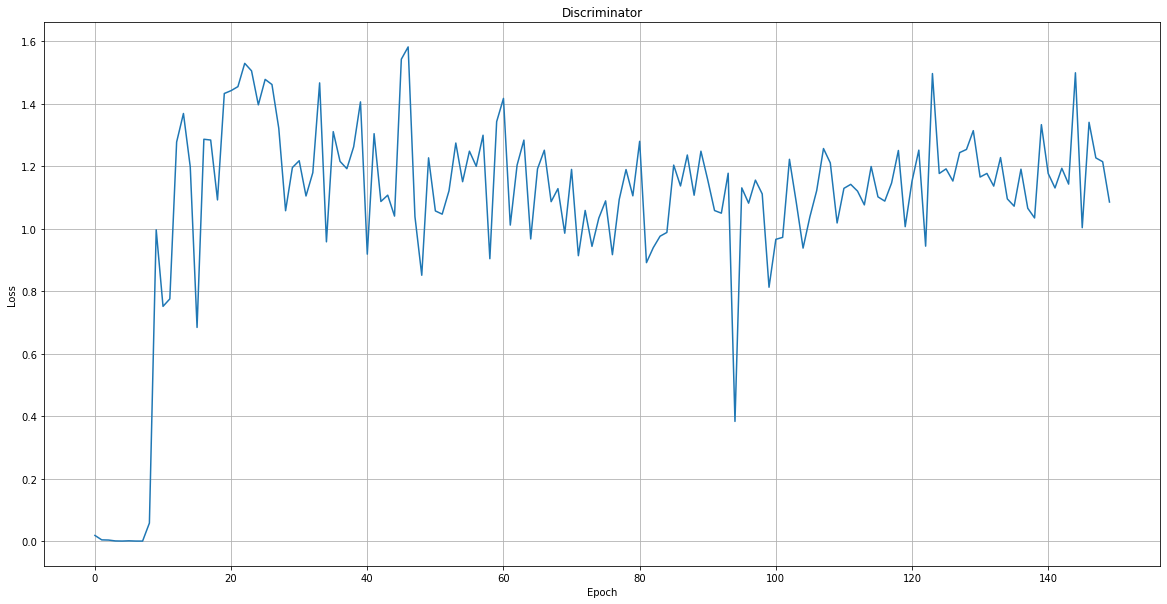

In [21]:
plot_losses(g_loss, 'Generator')
plot_losses(d_loss, 'Discriminator')